# MPAS Experiments Temperarture Moisture composite

## import package

In [1]:
import sys
import numpy as np
import joblib as jl
import netCDF4 as nc
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append('/home/b11209013/Package/')
import Theory as th # type: ignore
import DataProcess as dp # type: ignore
import SignalProcess as sp # type: ignore

## Load data

In [2]:
# case name
case = 'NSC'

# path
fname = f'/work/b11209013/2024_Research/MPAS/PC/{case}_PC.joblib'

# variable list
var_list = ['t', 'qv']

# load principal component data
data = jl.load(fname)

lon  = data['lon']
lat  = data['lat']
time = data['time']
pc1  = data['pc1'] # dictionary for t, q1, qv pc1
pc2  = data['pc2'] # dictionary for t, q1, qv pc2

ltime, llat, llon = pc1['t'].shape

# size of the pc: (time, lat, lon)

# load EOF structure
eof = jl.load('/work/b11209013/2024_Research/MPAS/PC/CNTL_EOF.joblib')

eof1 = eof[:, 0]
eof2 = eof[:, 1]

# load LRF file
lrf = jl.load('/work/b11209013/2024_Research/MPAS/LRF/lrf_CNTL.joblib')

lev = lrf['lev']
lw  = np.where(np.isnan(lrf['lw_lrf'])==True, 0, lrf['lw_lrf'])
sw  = np.where(np.isnan(lrf['sw_lrf'])==True, 0, lrf['sw_lrf'])
cu  = np.where(np.isnan(lrf['cu_lrf'])==True, 0, lrf['cu_lrf'])

llev = len(lev)

# load Q1 data
with nc.Dataset(f'/work/b11209013/2024_Research/MPAS/merged_data/{case}/q1.nc', 'r') as f:
    lon_q1  = f.variables['lon'][:]
    lat_q1  = f.variables['lat'][:]
    lev_q1  = f.variables['lev'][:]
    time_q1 = f.variables['time'][:]

    lat_lim = np.where((lat_q1>=-5) & (lat_q1<=5))[0]

    lat_q1 = lat_q1[lat_lim]
    q1     = f.variables['q1'][:, :, lat_lim, :]

q1_ave  = (q1[:, 1:]+q1[:, :-1])/2
q1_vint = -np.sum(q1_ave*np.diff(lev_q1)[None, :, None, None]*100, axis=1)
q1_vint *= 86400/9.8/2.5e6


## Reconstruct Profile

### Process PCs data

In [3]:
fmt = dp.Format(lat)
fmt_q1 = dp.Format(lat_q1)

sym = {
    'pc1':{
        var: fmt.sym(pc1[var])
        for var in var_list
    },
    'pc2': {
        var: fmt.sym(pc2[var])
        for var in var_list
    },
    'q1': fmt_q1.sym(q1_vint)
}

### FFT on PCs

In [4]:
fft = {
    'pc1':{
        var: np.fft.fftshift(np.fft.fft2(sym['pc1'][var]))[:, ::-1]
        for var in var_list
    },
    'pc2': {
        var: np.fft.fftshift(np.fft.fft2(sym['pc2'][var]))[:, ::-1]
        for var in var_list
    },
    'q1': np.fft.fftshift(np.fft.fft2(sym['q1']))[:, ::-1]
}

### Kelvin waves bandpass filter

In [5]:
wn = np.linspace(-359, 360, llon)
fr = np.linspace(-2, 2, ltime)

wnm, frm = np.meshgrid(wn, fr)

kel_curves = lambda ed, k: (86400/(2*np.pi*6.371e6))*np.sqrt(9.81*ed)*k

cond = (
    (wnm >= 1) & (wnm < 14) &
    (frm >= 1/20) & (frm <= 1/2.5) &
    (frm <= kel_curves(90, wnm)) & (frm >= kel_curves(8, wnm))
)

FFT_filtered = {
    'pc1': {
        var: np.where(cond, fft['pc1'][var]*2, 0)
        for var in var_list
    },
    'pc2': {
        var: np.where(cond, fft['pc2'][var]*2, 0)
        for var in var_list
    },
    'q1': np.where(cond, fft['q1']*2, 0)
}


### IFFT on Bandpassed temperature and moisture

In [6]:
Recon = {
    'pc1': {
        var: np.fft.ifft2(np.fft.ifftshift(FFT_filtered['pc1'][var][:, ::-1])).real
        for var in var_list
    },
    'pc2': {
        var: np.fft.ifft2(np.fft.ifftshift(FFT_filtered['pc2'][var][:, ::-1])).real
        for var in var_list
    },
    'q1': np.fft.ifft2(np.fft.ifftshift(FFT_filtered['q1'][:, ::-1])).real
}

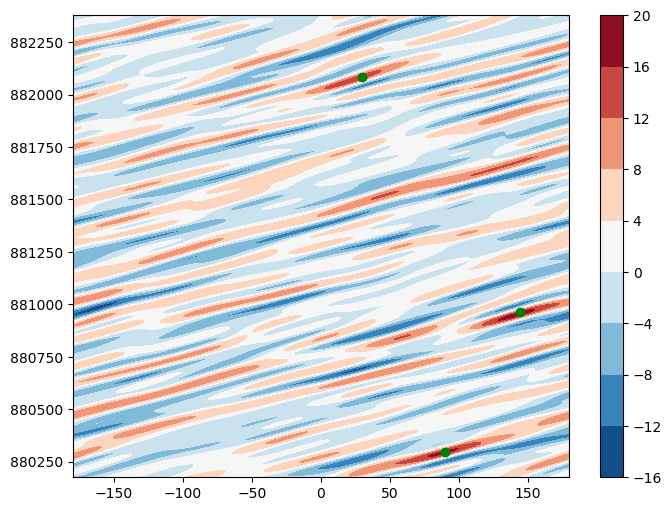

In [7]:
plt.figure(figsize=(8, 6))
c1 = plt.contourf(
    lon_q1, time_q1,
    Recon['q1'],
    cmap='RdBu_r'
)
plt.plot(90, time[20], 'go')
plt.plot(30, time[318], 'go')
plt.plot(144, time[131], 'go')
plt.colorbar(c1)
plt.show()

# CCKW event chosen:
# (-100, time[30])
# (50, time[241])
# (100, time[121])

## Select a cross-section (x-p) to test show corresponding heating profile of first/second baroclinic modes 

### Plot setting

In [8]:
plt.rcParams.update({
    'font.size': 10,
    'figure.titlesize': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'font.family': 'serif',
})

### Event choosing

In [9]:
time_selected = [20, 318, 131]
lon_selected  = [
    np.argmin(np.abs(lon_q1-lon_ref))
    for lon_ref in [90, 30, 144]
]

time_interval = np.array([
    np.linspace(i-16, i+16, 33).astype(int)
    for i in time_selected
])

time_ticks = np.linspace(-4, 4, 33)

print(time_interval.shape)

(3, 33)


### Selecting specific time interval

In [10]:
Sel_recon = {
    'pc1': {
        var: np.array([
            Recon['pc1'][var][time_interval[t_i], l_ref]
            for l_ref in lon_selected
            for t_i in range(time_interval.shape[0])
        ]).mean(axis=0)
        for var in var_list
    },
    'pc2': {
        var: np.array([
            Recon['pc2'][var][time_interval[t_i], l_ref]
            for l_ref in lon_selected
            for t_i in range(time_interval.shape[0])
        ]).mean(axis=0)
        for var in var_list
    },
}

jl.dump(Sel_recon, f'/home/b11209013/2024_Research/MPAS/LRF/composite_MPAS/composite_Tseries/{case}.joblib')

['/home/b11209013/2024_Research/MPAS/LRF/composite_MPAS/composite_Tseries/NSC.joblib']

### state vector

(36, 33)
-0.3075652637198875 0.34230566649433786


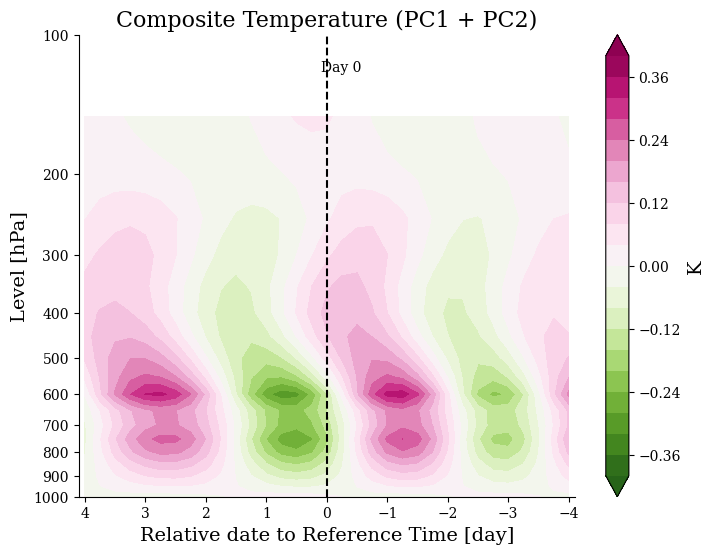

In [11]:
t_pc1_struct = eof1.reshape((-1, 1)) @ Sel_recon['pc1']['t'].reshape((1, -1))
t_pc2_struct = eof2.reshape((-1, 1)) @ Sel_recon['pc2']['t'].reshape((1, -1))
t_tot_struct = t_pc1_struct+ t_pc2_struct

q_pc1_struct = eof1.reshape((-1, 1)) @ Sel_recon['pc1']['qv'].reshape((1, -1))
q_pc2_struct = eof2.reshape((-1, 1)) @ Sel_recon['pc2']['qv'].reshape((1, -1))

state_pc1 = np.concatenate((t_pc1_struct, q_pc1_struct), axis=0)
state_pc2 = np.concatenate((t_pc2_struct, q_pc2_struct), axis=0)

plt.figure(figsize=(8, 6))
plt.contourf(
    time_ticks, lev,
    (t_pc1_struct+t_pc2_struct),
    levels=np.linspace(-0.4, 0.4, 21),
    cmap='PiYG_r',
    extend='both'
)
plt.axvline(0,color='k', linestyle='--')
plt.text(0.1, 120, 'Day 0')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yscale('log')
plt.xticks(np.linspace(-4, 4, 9))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
plt.xlim(4.1, -4.1)
plt.ylim(1000, 100)
plt.xlabel('Relative date to Reference Time [day]', fontsize=14)
plt.ylabel('Level [hPa]', fontsize=14)
plt.title('Composite Temperature (PC1 + PC2)', fontsize=16)
plt.colorbar(label='K')
print(state_pc2.shape)

print(np.min(t_tot_struct), np.max(t_tot_struct))

### longwave heating

In [12]:
lw_pc1 = lw @ state_pc1
lw_pc2 = lw @ state_pc2

lw_tot = lw_pc1+lw_pc2

### shortwave heating

In [13]:
sw_pc1 = sw @ state_pc1
sw_pc2 = sw @ state_pc2

sw_tot = sw_pc1 + sw_pc2

### cumulus heating

In [14]:
cu_pc1 = (cu @ state_pc1)[:18]
cu_pc2 = (cu @ state_pc2)[:18]

cu_tot = cu_pc1 + cu_pc2

## Plot out the cross setion of heating

### longwave

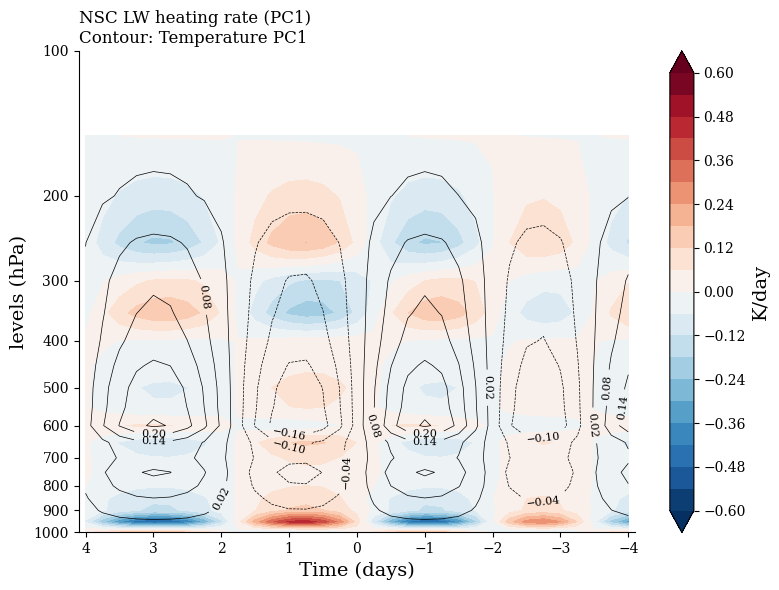

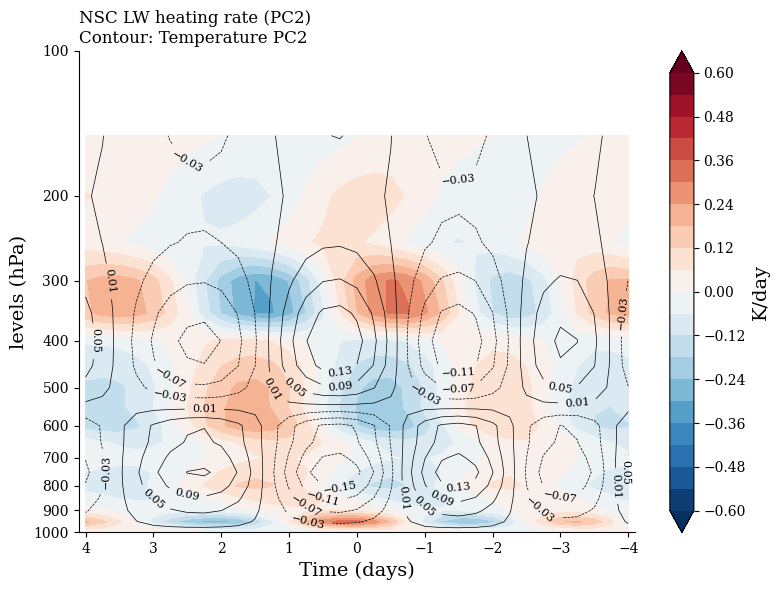

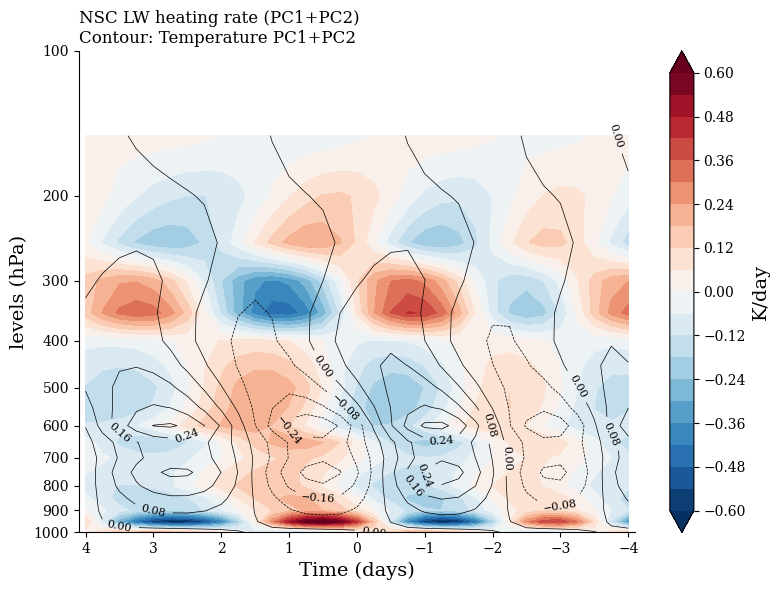

In [15]:
plt.figure(figsize=(8, 6))
cf1 = plt.contourf(
    time_ticks, lev, lw_pc1,
    cmap='RdBu_r',
    levels = np.linspace(-0.6, 0.6, 21),
    extend='both'
)
c1 = plt.contour(
    time_ticks, lev, t_pc1_struct,
    colors='k', linewidths=0.5,
    levels=np.linspace(-0.28, 0.32, 11)
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yscale('log')
plt.xticks(np.linspace(-4, 4, 9))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
plt.xlim(4.1, -4.1)
plt.ylim(1000, 100)
plt.xlabel('Time (days)')
plt.ylabel('levels (hPa)')
plt.title(
    f'{case} LW heating rate (PC1)\nContour: Temperature PC1',
    loc='left', fontsize=12
)
cbar1 = plt.colorbar(
    cf1,
    label='K/day',
)
cbar1.set_ticks(np.linspace(-0.6, 0.6, 11))
plt.clabel(c1, inline=True, fontsize=8)
plt.tight_layout()
plt.savefig(f'/home/b11209013/2024_Research/MPAS/LRF/comp_heating_image/{case}/LW_PC1.png')
plt.show()

# ====================================== #

plt.figure(figsize=(8, 6))
cf1 = plt.contourf(
    time_ticks, lev, lw_pc2,
    cmap='RdBu_r',
    levels = np.linspace(-0.6, 0.6, 21),
    extend='both'
)
c1 = plt.contour(
    time_ticks, lev, t_pc2_struct,
    colors='k', linewidths=0.5,
    levels=np.linspace(-0.27, 0.25, 14)
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yscale('log')
plt.xticks(np.linspace(-4, 4, 9))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
plt.xlim(4.1, -4.1)
plt.ylim(1000, 100)
plt.xlabel('Time (days)')
plt.ylabel('levels (hPa)')
plt.title(
    f'{case} LW heating rate (PC2)\nContour: Temperature PC2',
    loc='left', fontsize=12
)
cbar1 = plt.colorbar(
    cf1,
    label='K/day',
)
cbar1.set_ticks(np.linspace(-0.6, 0.6, 11))
plt.clabel(c1, inline=True, fontsize=8)
plt.tight_layout()
plt.savefig(f'/home/b11209013/2024_Research/MPAS/LRF/comp_heating_image/{case}/LW_PC2.png')
plt.show()

# ================================ #

plt.figure(figsize=(8, 6))
cf1 = plt.contourf(
    time_ticks, lev, lw_tot,
    cmap='RdBu_r',
    levels = np.linspace(-0.6, 0.6, 21),
    extend='both'
)
c1 = plt.contour(
    time_ticks, lev, t_tot_struct,
    colors='k', linewidths=0.5,
    levels=np.linspace(-0.4, 0.4, 11)
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yscale('log')
plt.xticks(np.linspace(-4, 4, 9))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
plt.xlim(4.1, -4.1)
plt.ylim(1000, 100)
plt.xlabel('Time (days)')
plt.ylabel('levels (hPa)')
plt.title(
    f'{case} LW heating rate (PC1+PC2)\nContour: Temperature PC1+PC2',
    loc='left', fontsize=12
)
cbar1 = plt.colorbar(
    cf1,
    label='K/day',
)
cbar1.set_ticks(np.linspace(-0.6, 0.6, 11))
plt.clabel(c1, inline=True, fontsize=8)
plt.tight_layout()
plt.savefig(f'/home/b11209013/2024_Research/MPAS/LRF/comp_heating_image/{case}/LW_tot.png')
plt.show()

### Shortwave heating

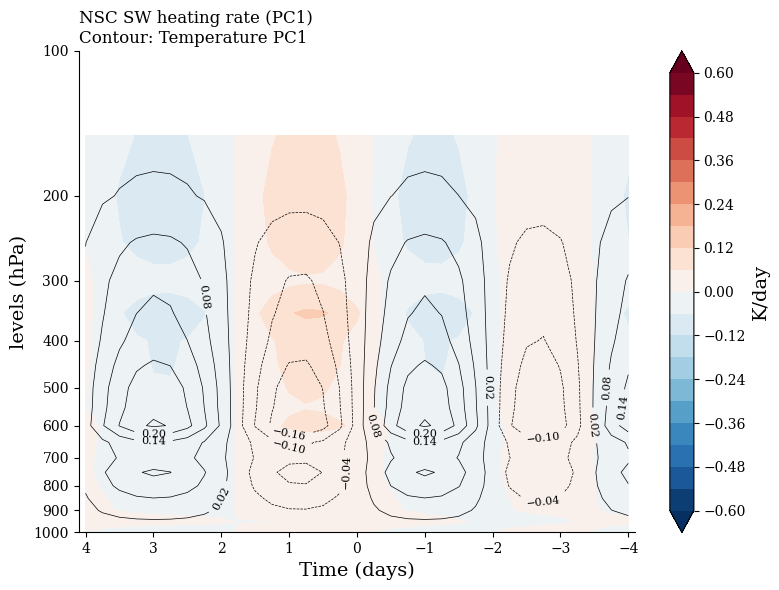

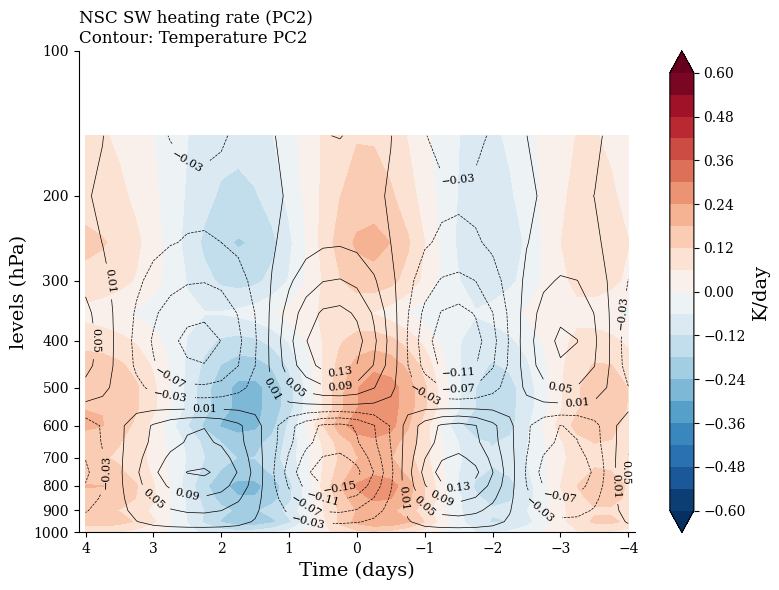

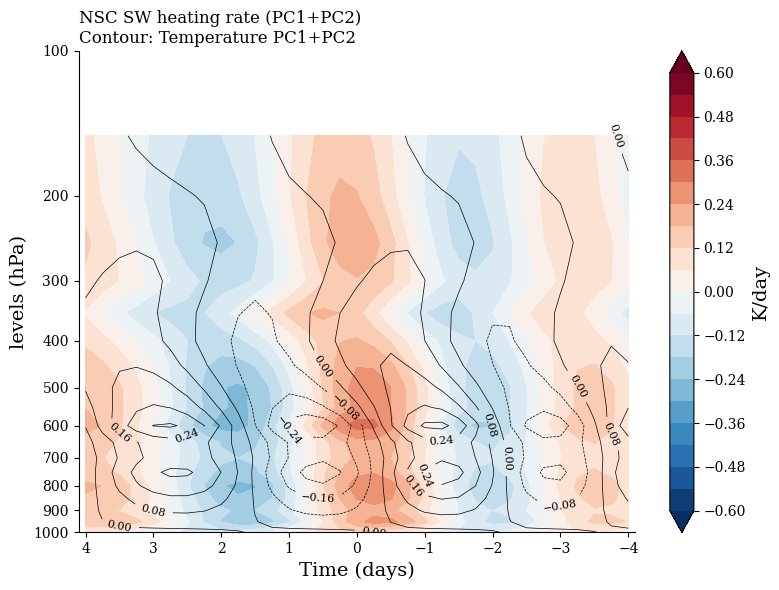

In [16]:
plt.figure(figsize=(8, 6))
cf1 = plt.contourf(
    time_ticks, lev, sw_pc1,
    cmap='RdBu_r',
    levels = np.linspace(-0.6, 0.6, 21),
    extend='both'
)
c1 = plt.contour(
    time_ticks, lev, t_pc1_struct,
    colors='k', linewidths=0.5,
    levels=np.linspace(-0.28, 0.32, 11)
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yscale('log')
plt.xticks(np.linspace(-4, 4, 9))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
plt.xlim(4.1, -4.1)
plt.ylim(1000, 100)
plt.xlabel('Time (days)')
plt.ylabel('levels (hPa)')
plt.title(
    f'{case} SW heating rate (PC1)\nContour: Temperature PC1',
    loc='left', fontsize=12
)
cbar1 = plt.colorbar(
    cf1,
    label='K/day',
)
cbar1.set_ticks(np.linspace(-0.6, 0.6, 11))
plt.clabel(c1, inline=True, fontsize=8)
plt.tight_layout()
plt.savefig(f'/home/b11209013/2024_Research/MPAS/LRF/comp_heating_image/{case}/SW_PC1.png')
plt.show()

# ====================================== #

plt.figure(figsize=(8, 6))
cf1 = plt.contourf(
    time_ticks, lev, sw_pc2,
    cmap='RdBu_r',
    levels = np.linspace(-0.6, 0.6, 21),
    extend='both'
)
c1 = plt.contour(
    time_ticks, lev, t_pc2_struct,
    colors='k', linewidths=0.5,
    levels=np.linspace(-0.27, 0.25, 14)
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yscale('log')
plt.xticks(np.linspace(-4, 4, 9))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
plt.xlim(4.1, -4.1)
plt.ylim(1000, 100)
plt.xlabel('Time (days)')
plt.ylabel('levels (hPa)')
plt.title(
    f'{case} SW heating rate (PC2)\nContour: Temperature PC2',
    loc='left', fontsize=12
)
cbar1 = plt.colorbar(
    cf1,
    label='K/day',
)
cbar1.set_ticks(np.linspace(-0.6, 0.6, 11))
plt.clabel(c1, inline=True, fontsize=8)
plt.tight_layout()
plt.savefig(f'/home/b11209013/2024_Research/MPAS/LRF/comp_heating_image/{case}/SW_PC2.png')
plt.show()

# ================================ #

plt.figure(figsize=(8, 6))
cf1 = plt.contourf(
    time_ticks, lev, sw_tot,
    cmap='RdBu_r',
    levels = np.linspace(-0.6, 0.6, 21),
    extend='both'
)
c1 = plt.contour(
    time_ticks, lev, t_tot_struct,
    colors='k', linewidths=0.5,
    levels=np.linspace(-0.4, 0.4, 11)
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yscale('log')
plt.xticks(np.linspace(-4, 4, 9))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
plt.xlim(4.1, -4.1)
plt.ylim(1000, 100)
plt.xlabel('Time (days)')
plt.ylabel('levels (hPa)')
plt.title(
    f'{case} SW heating rate (PC1+PC2)\nContour: Temperature PC1+PC2',
    loc='left', fontsize=12
)
cbar1 = plt.colorbar(
    cf1,
    label='K/day',
)
cbar1.set_ticks(np.linspace(-0.6, 0.6, 11))
plt.clabel(c1, inline=True, fontsize=8)
plt.tight_layout()
plt.savefig(f'/home/b11209013/2024_Research/MPAS/LRF/comp_heating_image/{case}/SW_tot.png')
plt.show()

## Cumulus

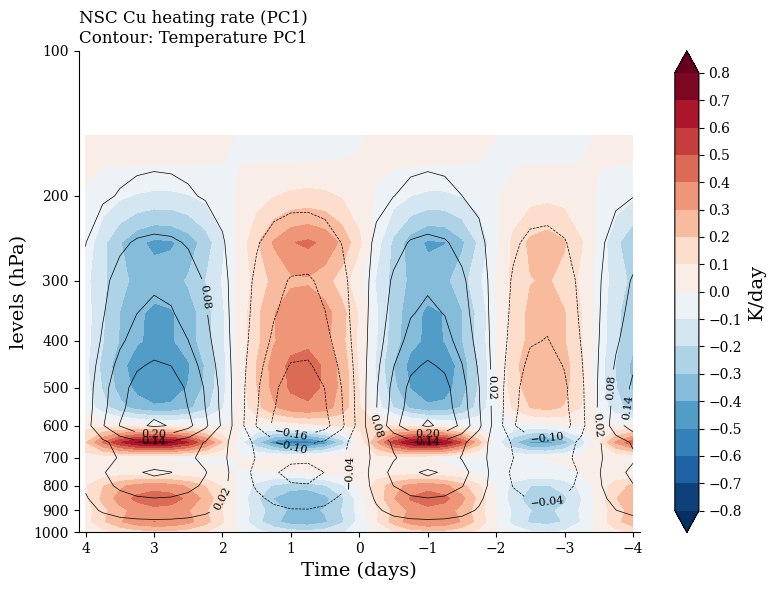

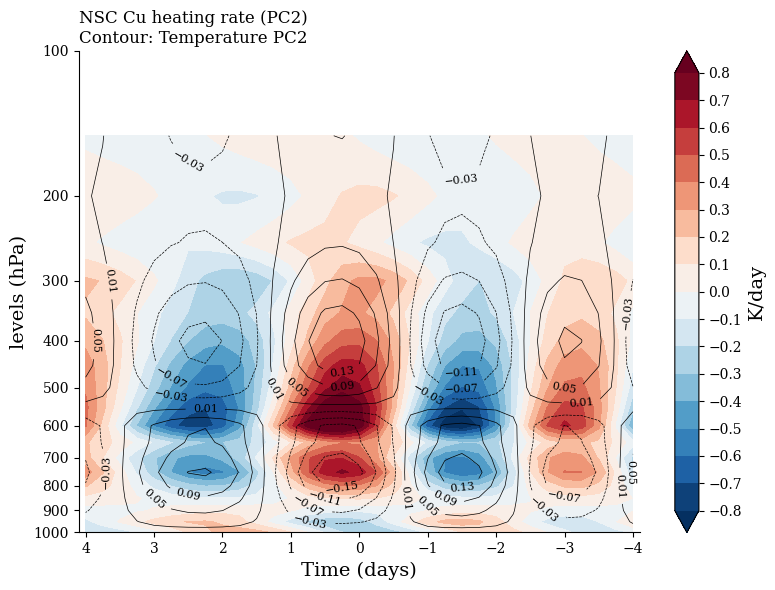

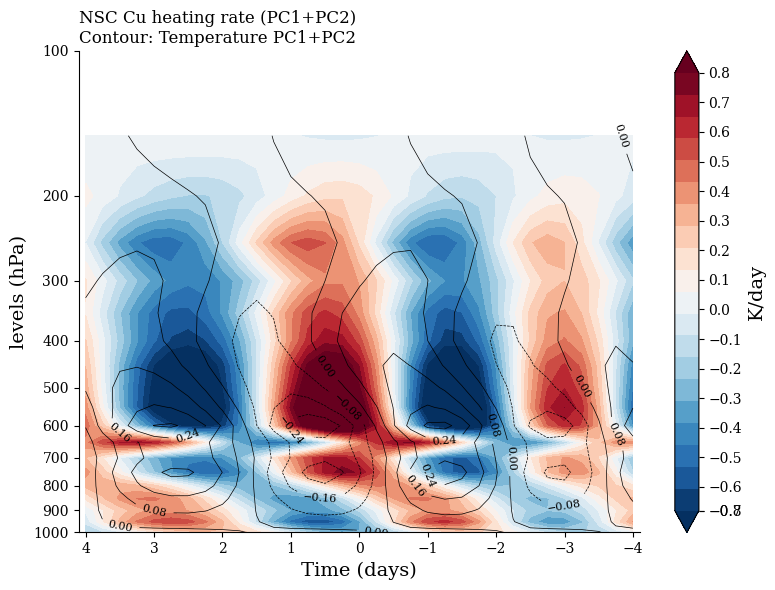

In [17]:
plt.figure(figsize=(8, 6))
cf1 = plt.contourf(
    time_ticks, lev, cu_pc1,
    cmap='RdBu_r',
    levels = np.linspace(-0.8, 0.8, 17),
    extend='both'
)
c1 = plt.contour(
    time_ticks, lev, t_pc1_struct,
    colors='k', linewidths=0.5,
    levels=np.linspace(-0.28, 0.32, 11)
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yscale('log')
plt.xticks(np.linspace(-4, 4, 9))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
plt.xlim(4.1, -4.1)
plt.ylim(1000, 100)
plt.xlabel('Time (days)')
plt.ylabel('levels (hPa)')
plt.title(
    f'{case} Cu heating rate (PC1)\nContour: Temperature PC1',
    loc='left', fontsize=12
)
cbar1 = plt.colorbar(
    cf1,
    label='K/day',
)
cbar1.set_ticks(np.linspace(-0.8, 0.8, 17))
plt.clabel(c1, inline=True, fontsize=8)
plt.tight_layout()
plt.savefig(f'/home/b11209013/2024_Research/MPAS/LRF/comp_heating_image/{case}/CU_PC1.png')
plt.show()

# ====================================== #

plt.figure(figsize=(8, 6))
cf1 = plt.contourf(
    time_ticks, lev, cu_pc2,
    cmap='RdBu_r',
    levels = np.linspace(-0.8, 0.8, 17),
    extend='both'
)
c1 = plt.contour(
    time_ticks, lev, t_pc2_struct,
    colors='k', linewidths=0.5,
    levels=np.linspace(-0.27, 0.25, 14)
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yscale('log')
plt.xticks(np.linspace(-4, 4, 9))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
plt.xlim(4.1, -4.1)
plt.ylim(1000, 100)
plt.xlabel('Time (days)')
plt.ylabel('levels (hPa)')
plt.title(
    f'{case} Cu heating rate (PC2)\nContour: Temperature PC2',
    loc='left', fontsize=12
)
cbar1 = plt.colorbar(
    cf1,
    label='K/day',
)
cbar1.set_ticks(np.linspace(-0.8, 0.8, 17))
plt.clabel(c1, inline=True, fontsize=8)
plt.tight_layout()
plt.savefig(f'/home/b11209013/2024_Research/MPAS/LRF/comp_heating_image/{case}/CU_PC2.png')
plt.show()

# ================================ #

plt.figure(figsize=(8, 6))
cf1 = plt.contourf(
    time_ticks, lev, cu_tot,
    cmap='RdBu_r',
    levels = np.linspace(-0.68, 0.8, 21),
    extend='both'
)
c1 = plt.contour(
    time_ticks, lev, t_tot_struct,
    colors='k', linewidths=0.5,
    levels=np.linspace(-0.4, 0.4, 11)
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yscale('log')
plt.xticks(np.linspace(-4, 4, 9))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
plt.xlim(4.1, -4.1)
plt.ylim(1000, 100)
plt.xlabel('Time (days)')
plt.ylabel('levels (hPa)')
plt.title(
    f'{case} Cu heating rate (PC1+PC2)\nContour: Temperature PC1+PC2',
    loc='left', fontsize=12
)
cbar1 = plt.colorbar(
    cf1,
    label='K/day',
)
cbar1.set_ticks(np.linspace(-0.8, 0.8, 17))
plt.clabel(c1, inline=True, fontsize=8)
plt.tight_layout()
plt.savefig(f'/home/b11209013/2024_Research/MPAS/LRF/comp_heating_image/{case}/CU_tot.png')
plt.show()

## Combining all heating source and plot out column-integrated time series

### Compute column integrated value

In [18]:
tot_heating = sw_tot + lw_tot + cu_tot

t_mean = np.sum(
    (t_tot_struct[1:]+t_tot_struct[:-1])/2*np.diff(lev)[:, None]*100,
    axis=0
) / np.sum(np.diff(lev)*100, axis=0)

lw_mean = np.sum(
    (lw_tot[1:]+lw_tot[:-1])/2*np.diff(lev)[:, None]*100,
    axis=0
) / np.sum(np.diff(lev)*100, axis=0)

sw_mean = np.sum(
    (sw_tot[1:]+sw_tot[:-1])/2*np.diff(lev)[:, None]*100,
    axis=0
) / np.sum(np.diff(lev)*100, axis=0)

cu_mean = np.sum(
    (cu_tot[1:]+cu_tot[:-1])/2*np.diff(lev)[:, None]*100,
    axis=0
) / np.sum(np.diff(lev)*100, axis=0)

### Plot out 

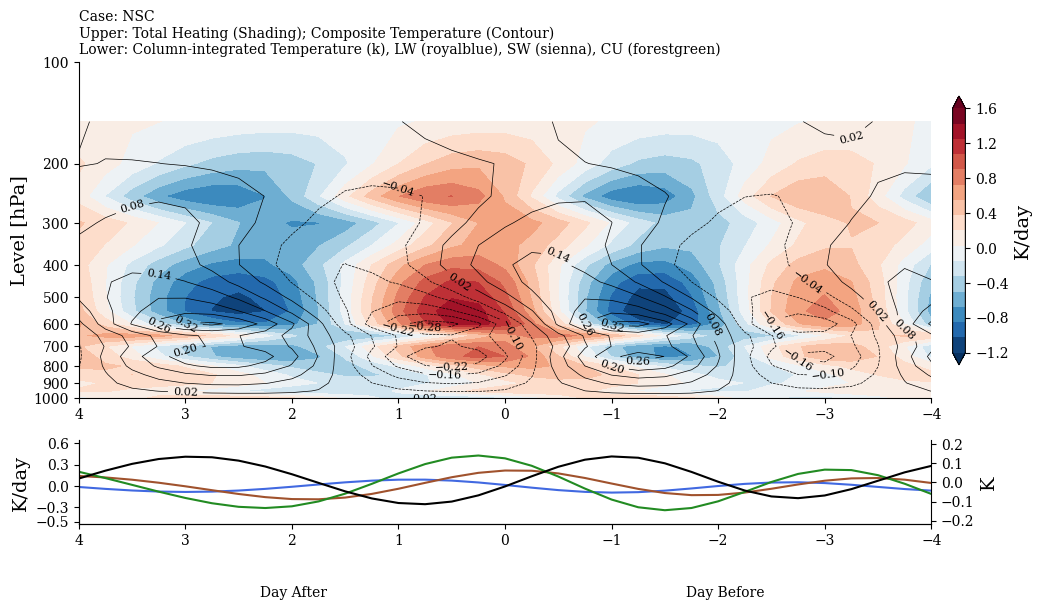

In [19]:
fig = plt.figure(figsize=(11, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])

# First subplot with contourf
ax1 = plt.subplot(gs[0])
cr1 = ax1.contourf(
    time_ticks, lev, tot_heating,
    cmap='RdBu_r',
    levels=np.linspace(-1.2, 1.6, 17),
    extend='both',
    norm=TwoSlopeNorm(vcenter=0),
)
c1 = ax1.contour(
    time_ticks, lev, t_tot_struct,
    colors='k',
    linewidths=0.5,
    levels=np.linspace(-0.28, 0.32, 11)
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yscale('log')
ax1.set_xlim(4, -4)
ax1.set_ylim(1000, 100)
ax1.set_yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
ax1.set_ylabel("Level [hPa]")
plt.clabel(c1, inline=True, fontsize=8)

# Second subplot with line plot
ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.plot(
    time_ticks, lw_mean,
    color='royalblue',
    label='LW'
)
ax2.plot(
    time_ticks, sw_mean,
    color='sienna',
    label='SW'
)
ax2.plot(
    time_ticks, cu_mean,
    color='forestgreen',
    label='Cu'
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
ax2.set_xlim(4, -4)
ax2.set_ylim(-0.54, 0.64)
ax2.set_xticks(np.linspace(4, -4, 9))
ax2.set_yticks([-0.5, -0.3, 0, 0.3, 0.6])
ax2.set_ylabel('K/day')

cax = inset_axes(ax1, width="1.5%", height="80%", loc="center right",
                 bbox_to_anchor=(0.04, 0, 1, 1), bbox_transform=ax1.transAxes, borderpad=0)


ax3 = ax2.twinx()
ax3.plot(
    time_ticks, t_mean,  # Plot data along the first row as an example
    color='k', 
    label='T'
)
plt.gca().spines['top'].set_visible(False)
ax3.set_ylabel('K')
ax3.set_ylim(-0.22, 0.22)
ax3.set_yticks(np.linspace(-0.2, 0.2, 5))

plt.text(2.3, -0.6, 'Day After')
plt.text(-1.7, -0.6, 'Day Before')

cbar = fig.colorbar(
    cr1, cax=cax, ax=[ax1, ax2], location="right",  label="K/day")
cbar.set_ticks(np.linspace(-1.2, 1.6, 8))

ax1.set_title(f'Case: {case}\n\
Upper: Total Heating (Shading); Composite Temperature (Contour)\n\
Lower: Column-integrated Temperature (k), LW (royalblue), SW (sienna), CU (forestgreen)',
fontsize=10, loc='left')
plt.savefig(f'/home/b11209013/2024_Research/MPAS/LRF/comp_heating_image/{case}/heating_total.png')
plt.show()